# Simple Classifiers and preprocessing of the data

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np


SEED = 42

## Importing of the data and spliting

next, we will import the dataset:

In [2]:
CSV_PATH = '../data/chartex_final.csv'

df = pd.read_csv(CSV_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_name         3932 non-null   object 
 1   track_pop          3932 non-null   int64  
 2   artist             3932 non-null   object 
 3   artist_pop         3932 non-null   int64  
 4   album              3932 non-null   object 
 5   danceability       3932 non-null   float64
 6   energy             3932 non-null   float64
 7   key                3932 non-null   float64
 8   loudness           3932 non-null   float64
 9   mode               3932 non-null   float64
 10  speechiness        3932 non-null   float64
 11  acousticness       3932 non-null   float64
 12  instrumentalness   3932 non-null   float64
 13  liveness           3932 non-null   float64
 14  valence            3932 non-null   float64
 15  tempo              3932 non-null   float64
 16  id                 3932 

Let's fill all missing data with the expectation:

In [3]:
df = df.drop(['track_name', 'artist', 'album', 'id', 'song_name', 'artist_name'], axis = 1, errors = 'ignore')
means = df.mean()
df.fillna(value=means, inplace=True)

next, we will split the target feature (number_of_videos) from the rest of the features and split to train and test sets. In addition, we will replace number_of_videos with a new binary feature that indicate if a track is popular on tiktok according to number_of_videos and threshold of our choice and it will be out target feature for **classification**:

In [4]:
from sklearn.model_selection import train_test_split

df = df.drop(['artist_pop', 'track_pop', 'number_of_videos_last_14days', 'total_likes_count', 'key'], axis = 1, errors = 'ignore')
columns = df.columns

X, y = df.drop(['number_of_videos'], axis=1, errors = 'ignore').values,  df['number_of_videos'].values

Let's look at the distribution of the target feature and also its mean and few quantiles:

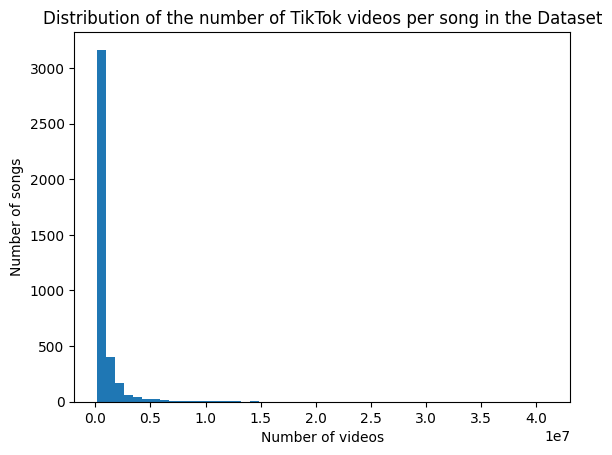

In [5]:
import matplotlib.pyplot as plt

plt.hist(y, bins=50)
plt.title("Distribution of the number of TikTok videos per song in the Dataset")
plt.xlabel("Number of videos")
plt.ylabel("Number of songs")
plt.show()

In [6]:
p = [0.3,0.4,0.5,0.6,0.7]
q = np.quantile(y, p)

print(f'Mean of target feature: {np.mean(y)} .')

for prob, quant in zip(p,q):
    print(f'The quantile of {prob} is {quant} .')

y_min = np.min(y)
y_max = np.max(y)

print(f'The max value is {y_max} and the min value is {y_min} .')
print(f'The range of the target feature is {y_max - y_min} .')

Mean of target feature: 794857.4763479145 .
The quantile of 0.3 is 230794.4 .
The quantile of 0.4 is 277940.0 .
The quantile of 0.5 is 345250.0 .
The quantile of 0.6 is 443660.0 .
The quantile of 0.7 is 607300.0 .
The max value is 41049300 and the min value is 147400 .
The range of the target feature is 40901900 .


We can notice that the mean of y is higher than the quantile of 0.7 (which is make sense considering the distribution of the target, as we can see in the plot above). We wish to have as balanced as possible data and therefore the mean is not the right threshold. On the other hand, the median is very low value considering the min and max of the target (it is very close to the min and very far from the max). Therefore, we will choose 500,000 as the threshold (still balanced).

In [7]:
y = (y > 5e5).astype('int32')

To conclude, for now, the features we will work on are:

In [8]:
print(f'Target: number_of_videos')
i = 0
for column in columns:
    if not column == 'number_of_videos':
        print(f'#{i} : {column}')
        i+=1

Target: number_of_videos
#0 : danceability
#1 : energy
#2 : loudness
#3 : mode
#4 : speechiness
#5 : acousticness
#6 : instrumentalness
#7 : liveness
#8 : valence
#9 : tempo
#10 : duration_ms
#11 : time_signature
#12 : chroma_stft
#13 : rmse
#14 : spec_cent
#15 : spec_bw
#16 : rolloff
#17 : zcr
#18 : mfcc


And now we will split the data between training and test sets:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's investigate a bit the train and test sets:

In [11]:
print("Train:")
print("#samples in train:", y_train.shape[0])
print("#popular samples in train:", y_train.sum().item()/y_train.shape[0])

print("\nTest:")
print("#samples in test:", y_test.shape[0])
print("#popular samples in test:", y_test.sum().item()/y_test.shape[0])

Train:
#samples in train: 2949
#popular samples in train: 0.35232282129535436

Test:
#samples in test: 983
#popular samples in test: 0.38351983723296035


## Simple classifiers:

In [12]:
from sklearn.model_selection import cross_validate
import torch

def print_accuracy(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    train_acc = (y_train == y_pred).mean()
    print("train accuracy =",train_acc)

    y_pred = model.predict(X_test)
    test_acc = (y_test == y_pred).mean()
    print("test accuracy =",test_acc)
    return train_acc,test_acc

def print_accuracy_prob(model, X_train, X_test, y_train, y_test):
    y_pred = model(X_train)
    train_acc = (torch.argmax(y_pred,dim=1) == y_train).type(torch.float32).mean().item()
    print("train accuracy =",train_acc)

    y_pred = model(X_test)
    test_acc = (torch.argmax(y_pred,dim=1) == y_test).type(torch.float32).mean().item()
    print("test accuracy =",test_acc)
    return train_acc,test_acc

splitted_data = (X_train, X_test, y_train, y_test)

In [13]:
clf_results = {'name': [], 'train_acc': [], 'test_acc': []}

### KNN

Now we are ready to train the models.

We will start with KNN:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=8)

knn_model.fit(X_train,y_train)

In [ ]:
train_acc, test_acc = print_accuracy(knn_model, *splitted_data)
clf_results['name'].append('KNN with K=8')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

### SVM with RBF kernel:

We will try to train SVM with RBF kernel:

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(gamma='auto')
svm_model.fit(X_train,y_train)

In [ ]:
train_acc, test_acc = print_accuracy(svm_model, *splitted_data)
clf_results['name'].append('SVM with RBF without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

In [ ]:
gammas = [0.01, 0.1, 1, 10, 100]
reg_terms = [0.01, 0.1, 1, 10, 100]
accuracy_per_value = []

for reg in reg_terms:
    for gamma in gammas:
        svm_model = SVC(C=reg, gamma=gamma)
        cv_result = cross_validate(svm_model, X_train, y_train, cv=3, scoring= ('accuracy'))
        accuracy_per_value.append(cv_result['test_score'].mean())

optim_idx = np.argmax(accuracy_per_value)
svm_model = SVC(C=reg_terms[optim_idx//len(gammas)], gamma=gammas[optim_idx%len(gammas)])
svm_model.fit(X_train, y_train)

In [ ]:
train_acc, test_acc = print_accuracy(svm_model, *splitted_data)
clf_results['name'].append('SVM with RBF with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

### Decision Trees:

Let's put regularization by forcing all leaves in the tree to have at least 10 samples from the training set:

In [ ]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10)

tree_model.fit(X_train, y_train)

In [ ]:
train_acc, test_acc = print_accuracy(tree_model, *splitted_data)
clf_results['name'].append('Decision Tree without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

Has we can see from the result, the model suffers from overfitting. So, let's do cross validation on min_samples_split:

In [ ]:
from sklearn import tree

list_of_mins = [10,50,100,300,500,1000]
accuracy_per_value = []

for min_leaf in list_of_mins:
    tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_leaf)
    cv_result = cross_validate(tree_model, X_train, y_train, cv=3, scoring= ('accuracy'))
    accuracy_per_value.append(cv_result['test_score'].mean())

optim_min = list_of_mins[np.argmax(accuracy_per_value)]
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = optim_min)
tree_model.fit(X_train, y_train)

And then, the accuracies of the model with the optimal min_samples_split is:

In [ ]:
train_acc, test_acc = print_accuracy(tree_model, *splitted_data)
clf_results['name'].append('Decision Tree with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

Still not a good result. We need to remember that we are still working on the row data and didn't do any feature mapping

### AdaBoost classifier:

Let's play with AdaBoost a bit:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

#the base model is stump - decision tree with maximal depth of 1.
adaboost_model = AdaBoostClassifier(n_estimators=50, learning_rate=20)
adaboost_model.fit(X_train, y_train)

In [ ]:
train_acc, test_acc = print_accuracy(adaboost_model, *splitted_data)
clf_results['name'].append('Adaboost without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

Let's see if Cross validation can help it:

In [ ]:
estimators = [10, 25, 50]
lr = [0.01, 0.1, 1]
accuracy_per_value = []

for n_estimator in estimators:
    for rate in lr:
        adaboost_model = AdaBoostClassifier(n_estimators=n_estimator, learning_rate= rate)
        cv_result = cross_validate(adaboost_model, X_train, y_train, cv=3, scoring= ('accuracy'))
        accuracy_per_value.append(cv_result['test_score'].mean())

optim_idx = np.argmax(accuracy_per_value)
adaboost_model = AdaBoostClassifier(n_estimators= estimators[optim_idx//len(lr)], learning_rate= lr[optim_idx%len(lr)])
adaboost_model.fit(X_train, y_train)

In [ ]:
train_acc, test_acc = print_accuracy(adaboost_model, *splitted_data)
clf_results['name'].append('Adaboost with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

### MLP model:

Let's check how many features we have:

In [14]:
input_dim = X_train.shape[1]
output_dim = 2
train_samples = X_train.shape[0]

print("input dim:", input_dim)
print("number of train samples:", train_samples)
print("number of test samples:", X_test.shape[0])

input dim: 19
number of train samples: 2949
number of test samples: 983


In [15]:
import torch
import torch.nn as nn
from src.RNN_utils.dataset import SimpleDS
from kornia.losses.focal import BinaryFocalLossWithLogits

torch.manual_seed(SEED)

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.long)

splitted_data_torch = (X_train, X_test, y_train, y_test)

#### Overfitting on small subset test:

We will start by checking if it is possible to overfit the MLP on small subset of the training set: (in order to see if the implementation of trainer and dataIterator module are good):

In [16]:
train_ds = SimpleDS(X_train[:50], y_train[:50])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=False)

In [ ]:
overfit_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 16),
    nn.LeakyReLU(),
    nn.Linear(16, output_dim),
    nn.Softmax(dim=1)
)

print(overfit_model)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=1)

In [ ]:
from src.RNN_utils.trainer import trainer

overfit_trainer = trainer(overfit_model, loss_fn, optimizer,scheduler)

loss_list, accuracy_list = overfit_trainer.train(train_dl, 100, False)

Success! Now we can move on to a real training.

#### Simple MLP:

In [16]:
train_ds = SimpleDS(X_train, y_train)
test_ds = SimpleDS(X_test, y_test)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [37]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

print(mlp_model)

Sequential(
  (0): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=19, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=2, bias=True)
  (6): Softmax(dim=1)
)


In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.2)

num_epochs = 100

In [39]:
from src.RNN_utils.trainer import trainer

mlp_trainer = trainer(mlp_model, loss_fn, optimizer, scheduler)

results = mlp_trainer.train(train_dl, num_epochs, False)

100%|██████████| 100/100 [00:15<00:00,  6.52it/s]

Epoch #99: Loss - 54.70751765370369, Accuracy - 0.7134621905730756


In [40]:
import matplotlib.pyplot as plt

def plotTrainRes(resutls, num_epochs):
    fig, axs = plt.subplots(1,2, figsize=(15,5))

    axs[0].plot(range(num_epochs), resutls['loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(num_epochs), resutls['accuracy'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')


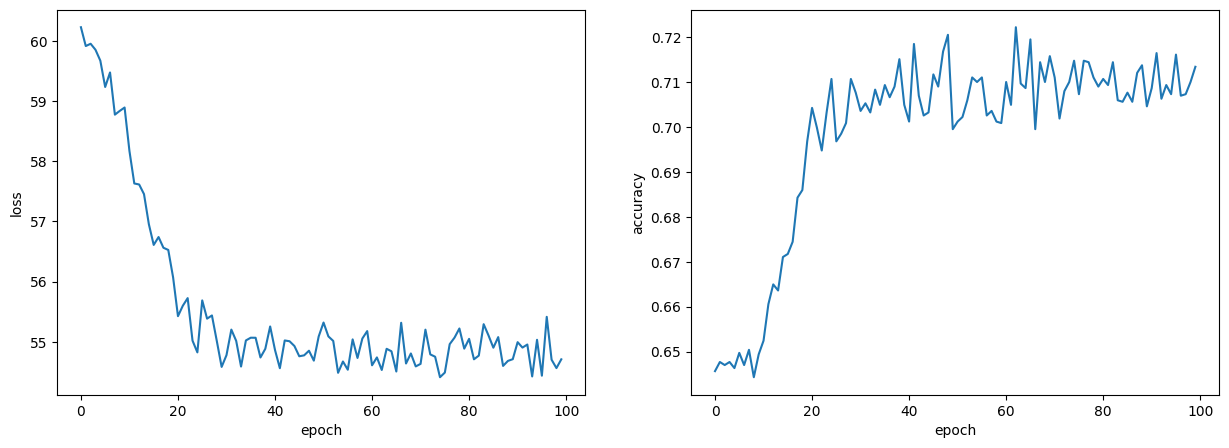

In [41]:
plotTrainRes(results,100)

In [42]:
train_acc, test_acc = print_accuracy_prob(mlp_model, *splitted_data_torch)
clf_results['name'].append('MLP without CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

train accuracy = 0.7344862818717957
test accuracy = 0.5869786143302917


It seems that the learning rate is not correct because the loss graph is fluctuating.

We will next do cross validation on few hyperparameters in order to get the better model but first we would like to see what the model learns.

#### Confusion Matrix and determine model architecture:

In [43]:
from torchmetrics.classification import ConfusionMatrix

In ordert to understand better what the model has learned, we will use confusion matrix.

A confusion matrix of binary classification is 2x2 matrix where each column represent the predicted class and each row the real class.

Let's start with the Simple MLP architecture:

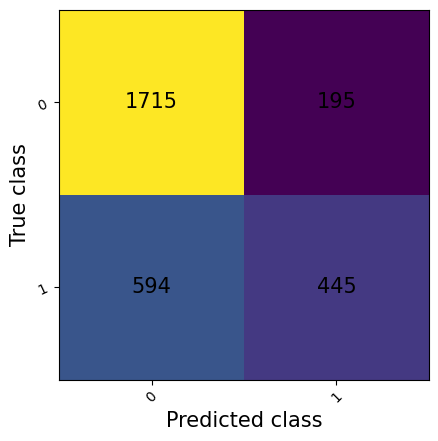

In [44]:
metric = ConfusionMatrix(task='binary', num_classes=2)
mlp_trainer.model.eval()
metric.update(mlp_trainer.model(X_train)[:,1], y_train)
fig_, ax_ = metric.plot()

We can notice that the model has high error FN (False Negative), meaning that it classify lots of viral songs as non-viral. In other words, the model prefer to classify samples as non-viral because the relative error in the misclassified viral song is much higher then in the non-viral (50% comapre to 5%). This can indicate that we should punish the model more on misclassified viral song, maybe with focal loss.

But first, let's try to change the architecture of the model:

In [45]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, output_dim),
    nn.Softmax(dim=1)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=5e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=35,gamma=0.5)
mlp_model.train()
trainer_obj = trainer(mlp_model,loss_fn,optimizer,scheduler)
results = trainer_obj.train(train_dl,100,False)

100%|██████████| 100/100 [00:18<00:00,  5.41it/s]

Epoch #99: Loss - 39.19923636317253, Accuracy - 0.8931841302136317


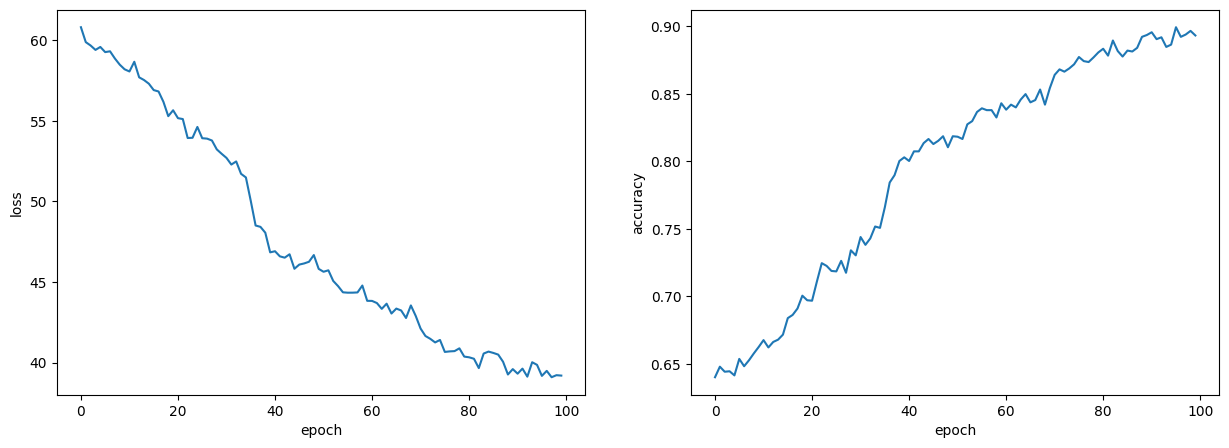

In [46]:
plotTrainRes(results,100)


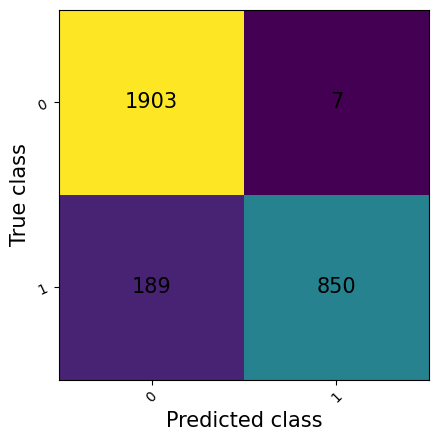

In [47]:
metric = ConfusionMatrix(task='binary', num_classes=2)
trainer_obj.model.eval()
metric.update(trainer_obj.model(X_train)[:,1], y_train)
fig_, ax_ = metric.plot()

Here we can see a much better confusion matrix, but at the same time the generalization is not good. We are in a risk of overfitting to the training set because of the high capacity of the model, but we succeed in learning (not generalizing) so we will continue with this architecture and apply techniques to prevent overfitting.

#### Cross validation for MLP:

In [48]:
import torch
import torch.nn as nn
from torchmetrics.classification import ConfusionMatrix
from src.cross_val import setConfigure
from src.RNN_utils.cross_val import crossValidate
from src.RNN_utils.trainer import trainer

In [49]:
CV_obj = crossValidate(train_ds,4,64)

Let's start with Cross Validation without focal loss:

In [58]:
results = []
configs = []

In [30]:
def crossValidationOnHP(config, num_epochs = 100, FL = False):
    mlp_model = nn.Sequential(
                nn.BatchNorm1d(input_dim),
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Dropout1d(p=0.4),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Dropout1d(p=0.4),
                nn.Linear(256, output_dim),
                nn.Softmax(dim=1)
            )
    print(f'The configuration is {config}:')
    if FL:
        loss_fn = BinaryFocalLossWithLogits(alpha=config['alpha'], gamma=config['gamma_fl'], reduction='mean', weight=config['weight'])
    else:
        loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])
    trainer_obj = trainer(mlp_model,loss_fn,optimizer,scheduler)
    return CV_obj.runCV(trainer_obj,num_epochs,verbose=False)

In [206]:
configs.append({'lr': 1e-3, 'weight_decay': 9e-4, 'step_size': 15, 'gamma': 0.2})
results.append(crossValidationOnHP(configs[-1], FL= False))

The configuration is {'lr': 0.001, 'weight_decay': 0.0009, 'step_size': 15, 'gamma': 0.2}:
Fold #0:
Result:  {'loss_train': 21.85265600681305, 'accuracy_train': 0.6739032112166441, 'loss_test': 7.929832696914673, 'accuracy_test': 0.6273712737127372}
Fold #1:
Result:  {'loss_train': 22.273160099983215, 'accuracy_train': 0.6609403254972875, 'loss_test': 7.4742066860198975, 'accuracy_test': 0.6729986431478969}
Fold #2:
Result:  {'loss_train': 22.032684087753296, 'accuracy_train': 0.6672694394213382, 'loss_test': 7.762667655944824, 'accuracy_test': 0.6445047489823609}
Fold #3:
Result:  {'loss_train': 21.90872013568878, 'accuracy_train': 0.6758589511754068, 'loss_test': 7.85789567232132, 'accuracy_test': 0.6350067842605156}


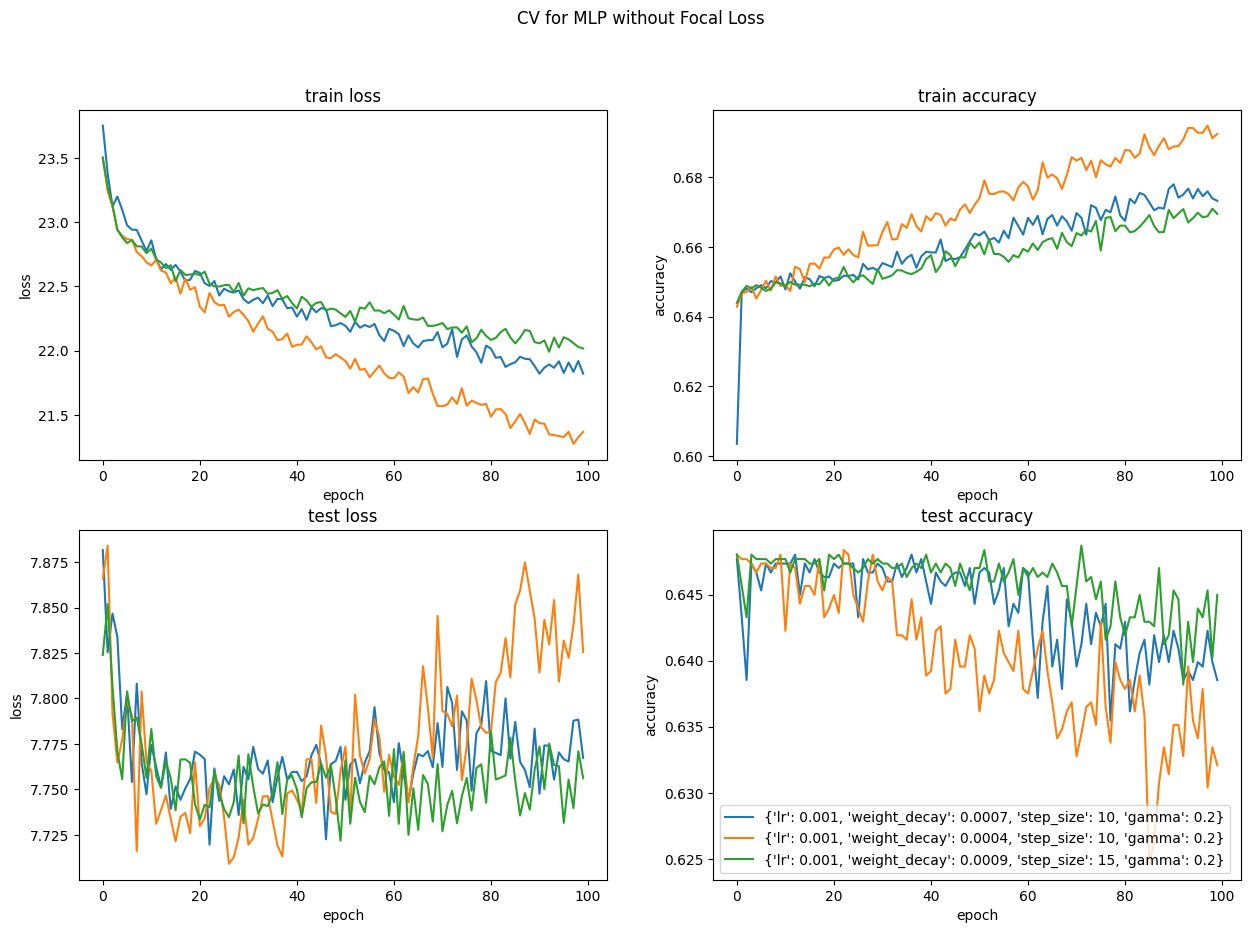

In [208]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV for MLP without Focal Loss')

Let's train the model with the green configuration and plot the confusion matrix on the training set:

In [52]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, output_dim),
    nn.Softmax(dim=1)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=0.2)
mlp_model.train()
trainer_obj = trainer(mlp_model,loss_fn,optimizer,scheduler)
results = trainer_obj.train(train_dl,100,False)

100%|██████████| 100/100 [00:21<00:00,  4.69it/s]

Epoch #99: Loss - 57.21726158261299, Accuracy - 0.6795523906408952


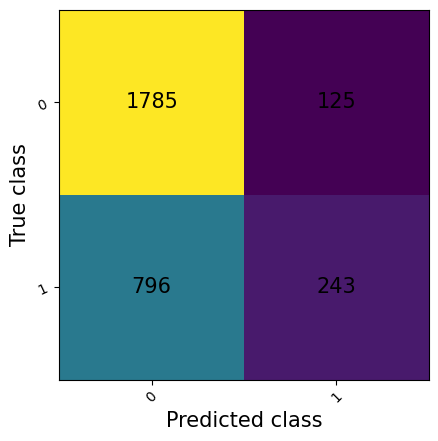

In [54]:
metric = ConfusionMatrix(task='binary', num_classes=2)
trainer_obj.model.eval()
metric.update(trainer_obj.model(X_train)[:,1], y_train)
fig_, ax_ = metric.plot()

And now let's add focal loss:

In [65]:
configs.append({'lr': 1e-4, 'weight_decay': 1e-4, 'step_size': 20, 'gamma': 0.5, 'alpha': 1.0, 'gamma_fl': 2, 'weight': torch.tensor([1.6,2.0])})
results.append(crossValidationOnHP(configs[-1], FL= True))

The configuration is {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 20, 'gamma': 0.5, 'alpha': 1.0, 'gamma_fl': 2, 'weight': tensor([1.6000, 2.0000])}:
Fold #0:
Result:  {'loss_train': 1.92419458553195, 'accuracy_train': 0.6793306196291271, 'loss_test': 0.6974882371723652, 'accuracy_test': 0.6138211382113821}
Fold #1:
Result:  {'loss_train': 1.9443452879786491, 'accuracy_train': 0.6613924050632911, 'loss_test': 0.6768545806407928, 'accuracy_test': 0.66078697421981}
Fold #2:
Result:  {'loss_train': 1.9483794569969177, 'accuracy_train': 0.6704339963833634, 'loss_test': 0.6857856623828411, 'accuracy_test': 0.6431478968792401}
Fold #3:
Result:  {'loss_train': 1.9249713085591793, 'accuracy_train': 0.6889692585895117, 'loss_test': 0.6930624917149544, 'accuracy_test': 0.6282225237449118}


In [55]:
results = results[1:]
configs = configs[1:]

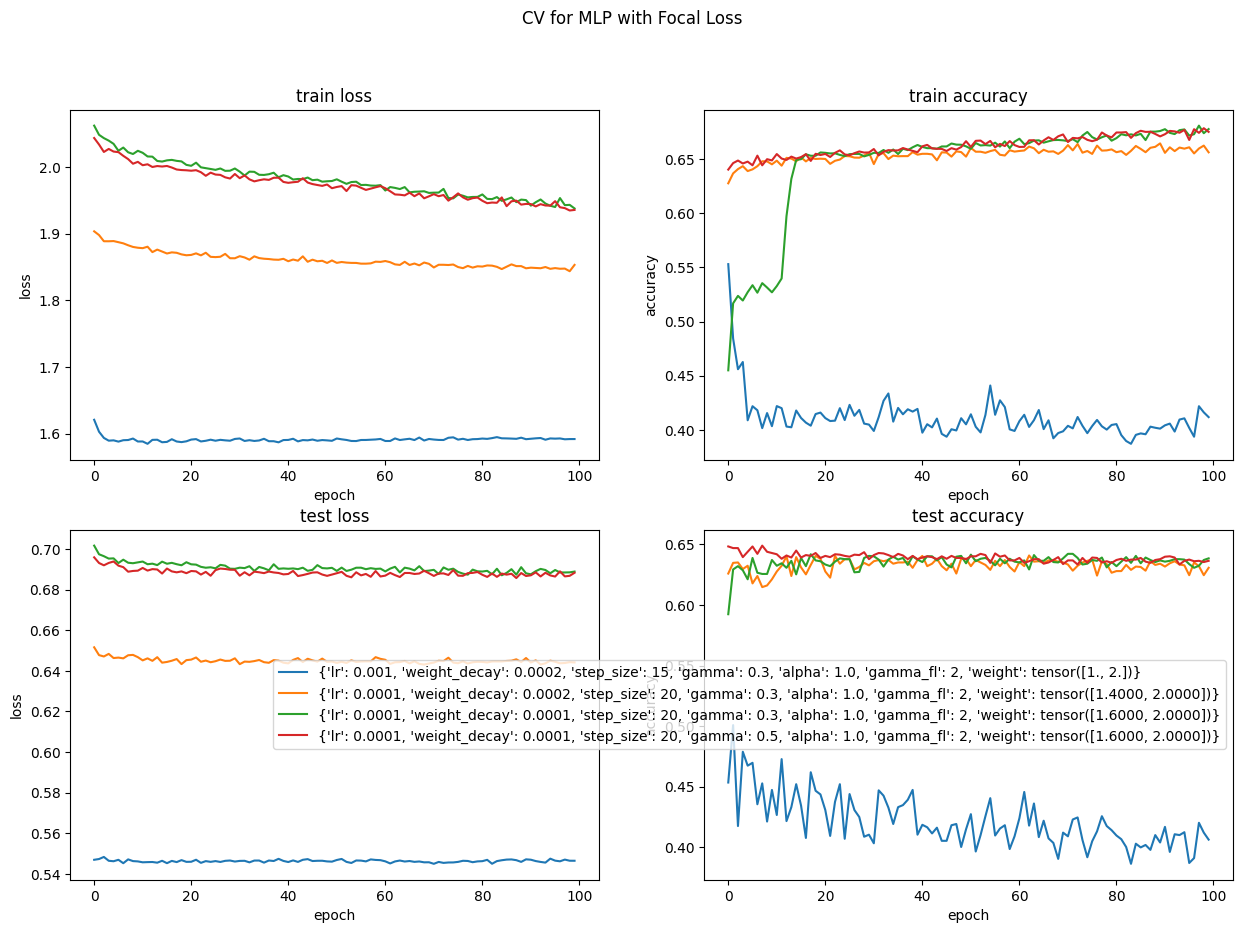

In [66]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV for MLP with Focal Loss')

Let's train the model with the red configuration and plot the confusion matrix on the training set:

In [67]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, output_dim),
    nn.Softmax(dim=1)
)
loss_fn = BinaryFocalLossWithLogits(alpha=1.0, gamma=2, reduction='mean', weight=torch.tensor([1.6,2.0]))
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.5)
mlp_model.train()
trainer_obj = trainer(mlp_model,loss_fn,optimizer,scheduler)
results = trainer_obj.train(train_dl,100,False)

100%|██████████| 100/100 [00:24<00:00,  4.05it/s]

Epoch #99: Loss - 5.041949488222599, Accuracy - 0.6870125466259749


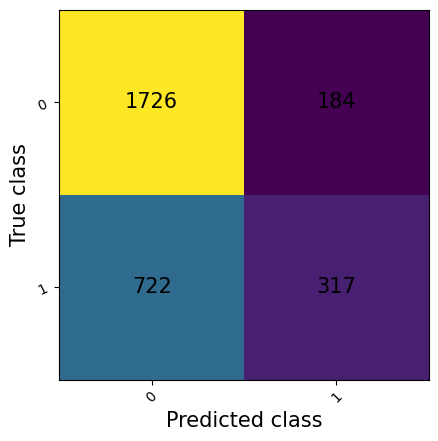

In [68]:
metric = ConfusionMatrix(task='binary', num_classes=2)
trainer_obj.model.eval()
metric.update(trainer_obj.model(X_train)[:,1], y_train)
fig_, ax_ = metric.plot()

#### Final Training:

In [ ]:
config = {'lr': 1e-3, 'weight_decay': 5e-4}

mlp_model = nn.Sequential(
        nn.BatchNorm1d(input_dim),
        nn.Linear(input_dim, 32),
        nn.LeakyReLU(),
        nn.Linear(32, 64),
        nn.LeakyReLU(),
        nn.Linear(64, output_dim),
        nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

mlp_trainer = trainer(mlp_model,loss_fn, optimizer, scheduler)

In [ ]:
train_res = mlp_trainer.train(train_dl=train_dl, epochs=100, verbose=False)

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(range(100), train_res['loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(100), train_res['accuracy'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')

In [ ]:
train_acc, test_acc = print_accuracy_prob(mlp_model, *splitted_data_torch)
clf_results['name'].append('MLP with CV')
clf_results['train_acc'].append(train_acc)
clf_results['test_acc'].append(test_acc)

Worse than without cross validation. We have a problem here.

### Conclusions:

Let's summarize the output:

In [ ]:
clf_dataframe = pd.DataFrame.from_dict(clf_results)
clf_dataframe

From the above table, adaBoost without CV got the best results on the training set. However, even the best is not good. As explained before, we think the reason for that is a missing for important feature that determine the popularity of songs. In other words, both spotify features and the self-extracted features we made are not enough to classify the popularity of songs. We hope that by working with the real audio, we will be able to extract this essential feature (or features) and will be able to do better than the results in this notebook.

### Others:

In [ ]:
#Save the entire model:
#torch.save(model, "my_model.pickle")
#model = torch.load("my_model.pickle")

#Save only the weights: (recommended)
#torch.save(model.state_dict(), "my_model.pickle")
#model = nn.Sequential(...)
#model.load_state_dict(torch.load("my_model.pickle"))